<a href="https://www.kaggle.com/code/klimyuriy/notebookafd484f38b?scriptVersionId=191452911" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'

dataset0 = datasets.ImageFolder(root=data_dir)

In [4]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'

dataset1 = datasets.ImageFolder(root=data_dir)

In [5]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

dataset2 = datasets.ImageFolder(root=data_dir)

In [6]:
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset0, dataset1, dataset2])

len(dataset)

10661

In [7]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [8]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [9]:
image_tensor, label = dataset[2]

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Grayscale(num_output_channels=1)
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Grayscale(num_output_channels=1)
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset[label]
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [11]:
len(train_data), len(val_data)

(8529, 2132)

In [12]:
dataset = TransformDataset(dataset, transform=train_transform)

In [13]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

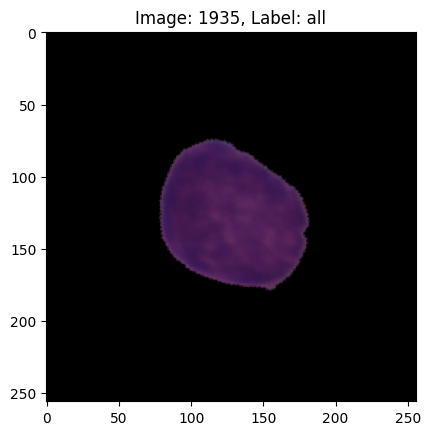

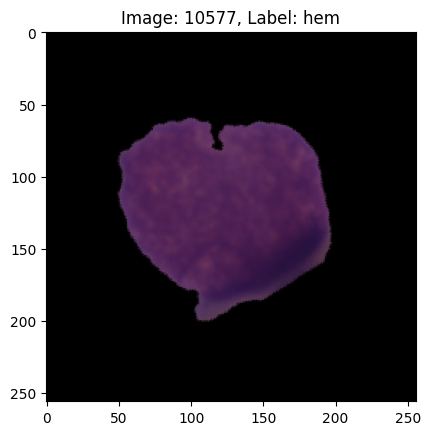

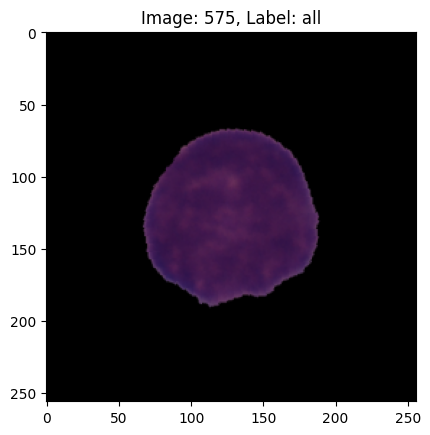

In [14]:
import matplotlib.pyplot as plt
import random

for _ in range(3):
    rand = random.randint(0, 10660) 
    img, label = dataset[rand]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset0.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {rand+1}, Label: {label_name}")
    plt.show()

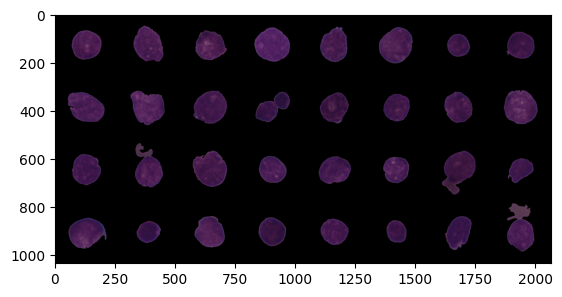

In [15]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)
  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [16]:
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(p=0.1)
        
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(32*6*6, num_classes)
        

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        
        out = self.pool(out)
    
        out = self.conv3(out)
        out = F.relu(out)
        
        out = self.pool(out)
        
        out = self.conv4(out)
        out = F.relu(out)
        
        out = self.pool(out)
        
        out = self.conv5(out)
        out = F.relu(out)
        
        out = self.pool(out)
        
        out = self.conv6(out)
        out = F.relu(out)
        
        out = self.pool(out)
        
        out = self.flat(out)
        
        out = self.dropout(out)
        
        out = self.linear(out)
        
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = FractureClassifier(len(train_data.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1152, out_features=2, bias=True)
)

In [17]:
!pip install -q torchsummary

In [18]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 252, 252]           1,168
         MaxPool2d-3         [-1, 16, 126, 126]               0
            Conv2d-4         [-1, 32, 124, 124]           4,640
         MaxPool2d-5           [-1, 32, 62, 62]               0
            Conv2d-6           [-1, 32, 60, 60]           9,248
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 32, 28, 28]           9,248
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 12, 12]           9,248
        MaxPool2d-11             [-1, 32, 6, 6]               0
          Flatten-12                 [-1, 1152]               0
          Dropout-13                 [-1, 1152]               0
           Linear-14                   

In [19]:
from collections import Counter

class_counts = Counter()
for _, label in dataset:
    class_counts[label] += 1

total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32).to(device)
weights

tensor([1.4660, 3.1458], device='cuda:0')

In [20]:
loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=2)

Epoch    1   92sec	loss:      0.542	val_loss:      0.532	accuracy_score:      0.755	val_accuracy_score:      0.765	
Epoch    2   91sec	loss:      0.507	val_loss:      0.535	accuracy_score:      0.782	val_accuracy_score:      0.746	
Epoch    4   90sec	loss:        0.5	val_loss:      0.527	accuracy_score:      0.784	val_accuracy_score:       0.78	
Epoch    6   89sec	loss:      0.494	val_loss:      0.531	accuracy_score:      0.792	val_accuracy_score:      0.785	
Epoch    8   89sec	loss:      0.486	val_loss:      0.515	accuracy_score:      0.792	val_accuracy_score:      0.778	
Epoch   10   89sec	loss:       0.48	val_loss:       0.55	accuracy_score:      0.798	val_accuracy_score:      0.795	
Epoch   12   89sec	loss:      0.474	val_loss:      0.507	accuracy_score:      0.801	val_accuracy_score:      0.792	
Epoch   14   89sec	loss:      0.452	val_loss:      0.488	accuracy_score:      0.819	val_accuracy_score:      0.803	
Epoch   16   89sec	loss:      0.428	val_loss:      0.492	accuracy_score:

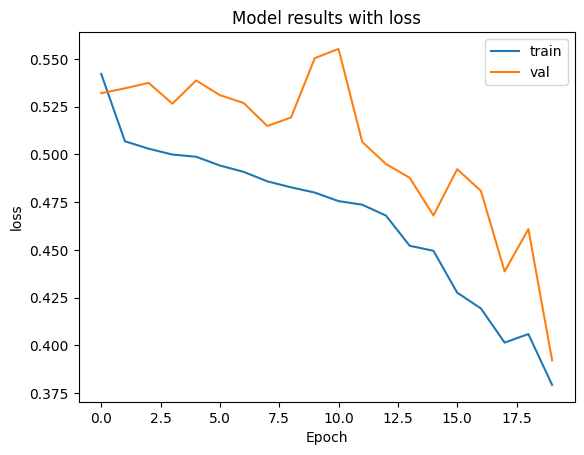

In [23]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

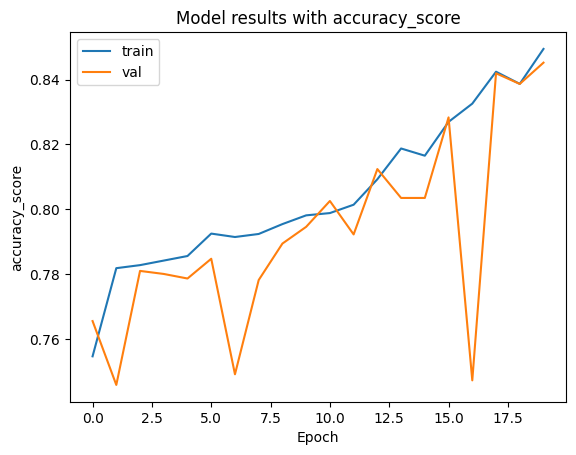

In [24]:
plot_metric(history, 'accuracy_score')

[]

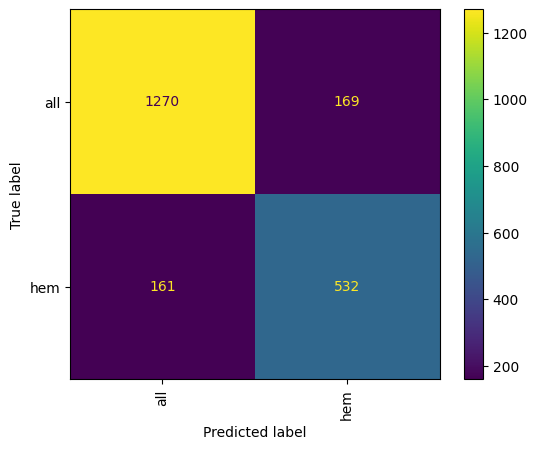

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset0.classes)
plt.xticks(rotation=90)
plt.plot()